[Filtered] Ventilatory Threshold estimated at VO2 ≈ 3197.00


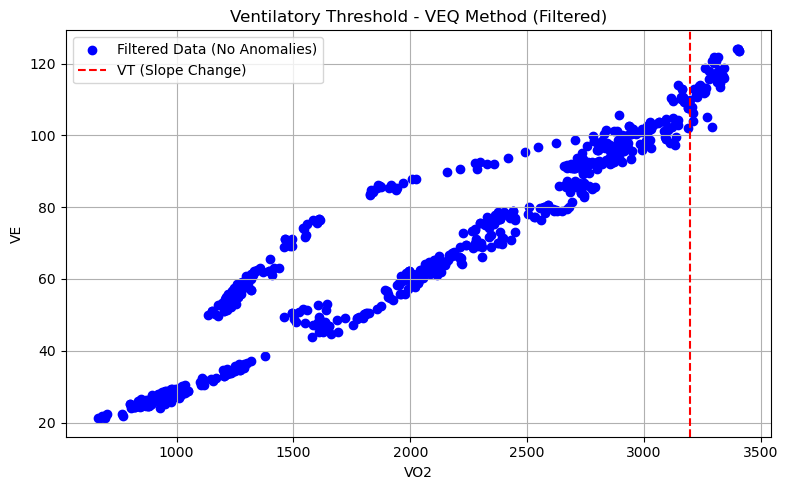

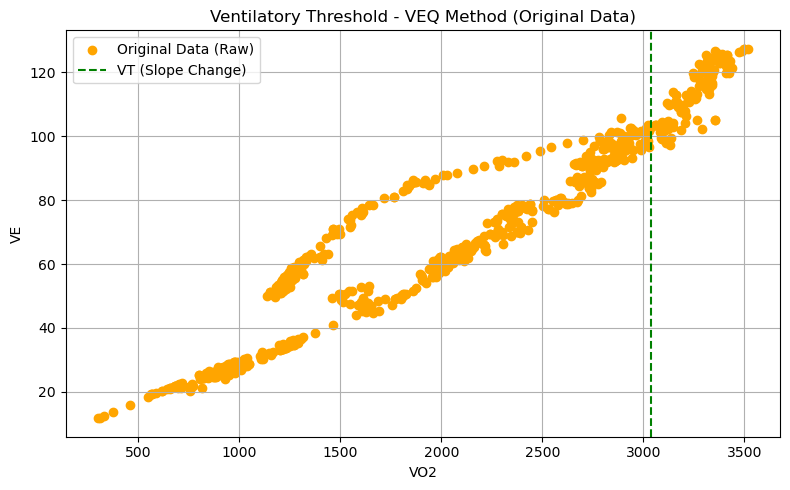

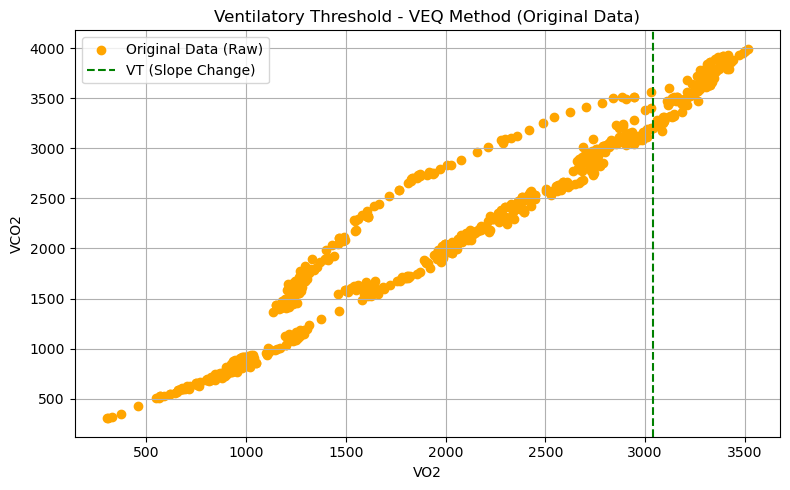

In [15]:
# METHOD 1 - VEQ-Method #


import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import IsolationForest
import pandas as pd
import os

# Set working directory and file path
working_directory = os.getcwd()
subject_info_path = os.path.join(working_directory, 'subject-info.csv')

# Load subject info data
subject_info = pd.read_csv(subject_info_path)
subject_measure_path = 'test_measure.csv'

# Load the dataset
data = pd.read_csv(subject_measure_path)

# Select specific ID_test
target_id_test = "610_1"
subset = data[data['ID_test'] == target_id_test]

# Drop missing values
subset = subset.dropna(subset=['VO2', 'VE'])

# --- Filtered Data (Anomalies Removed) ---
features = subset[['VO2', 'VE']].values
iso_forest = IsolationForest(contamination=0.10, random_state=42)
outlier_labels = iso_forest.fit_predict(features)

subset_filtered = subset[outlier_labels == 1]
x_filtered = subset_filtered['VO2'].values
y_filtered = subset_filtered['VE'].values

def find_best_split(x, y, min_points=5):
    best_split = None
    min_total_error = float('inf')

    for i in range(min_points, len(x) - min_points):
        model1 = LinearRegression().fit(x[:i].reshape(-1,1), y[:i])
        model2 = LinearRegression().fit(x[i:].reshape(-1,1), y[i:])

        error1 = np.sum((y[:i] - model1.predict(x[:i].reshape(-1,1)))**2)
        error2 = np.sum((y[i:] - model2.predict(x[i:].reshape(-1,1)))**2)

        total_error = error1 + error2

        if total_error < min_total_error:
            min_total_error = total_error
            best_split = i

    return best_split

# -- Plot for Filtered Data --
split_idx_filtered = find_best_split(x_filtered, y_filtered)
print(f"[Filtered] Ventilatory Threshold estimated at VO2 ≈ {x_filtered[split_idx_filtered]:.2f}")

plt.figure(figsize=(8, 5))
plt.scatter(x_filtered, y_filtered, color='blue', label='Filtered Data (No Anomalies)')
plt.axvline(x_filtered[split_idx_filtered], color='red', linestyle='--', label='VT (Slope Change)')
plt.xlabel('VO2')
plt.ylabel('VE')
plt.title('Ventilatory Threshold - VEQ Method (Filtered)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Original Data (No anomaly removal) ---
x_original = subset['VO2'].values
y_original = subset['VE'].values

# split_idx_original = find_best_split(x_original, y_original)
# print(f"[Original] Ventilatory Threshold estimated at VO2 ≈ {x_original[split_idx_original]:.2f}")

plt.figure(figsize=(8, 5))
plt.scatter(x_original, y_original, color='orange', label='Original Data (Raw)')
plt.axvline(x_original[split_idx_filtered], color='green', linestyle='--', label='VT (Slope Change)')
plt.xlabel('VO2')
plt.ylabel('VE')
plt.title('Ventilatory Threshold - VEQ Method (Original Data)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



x_original = subset['VO2'].values
y_original = subset['VCO2'].values

# split_idx_original = find_best_split(x_original, y_original)
# print(f"[Original] Ventilatory Threshold estimated at VO2 ≈ {x_original[split_idx_original]:.2f}")

plt.figure(figsize=(8, 5))
plt.scatter(x_original, y_original, color='orange', label='Original Data (Raw)')
plt.axvline(x_original[split_idx_filtered], color='green', linestyle='--', label='VT (Slope Change)')
plt.xlabel('VO2')
plt.ylabel('VCO2')
plt.title('Ventilatory Threshold - VEQ Method (Original Data)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


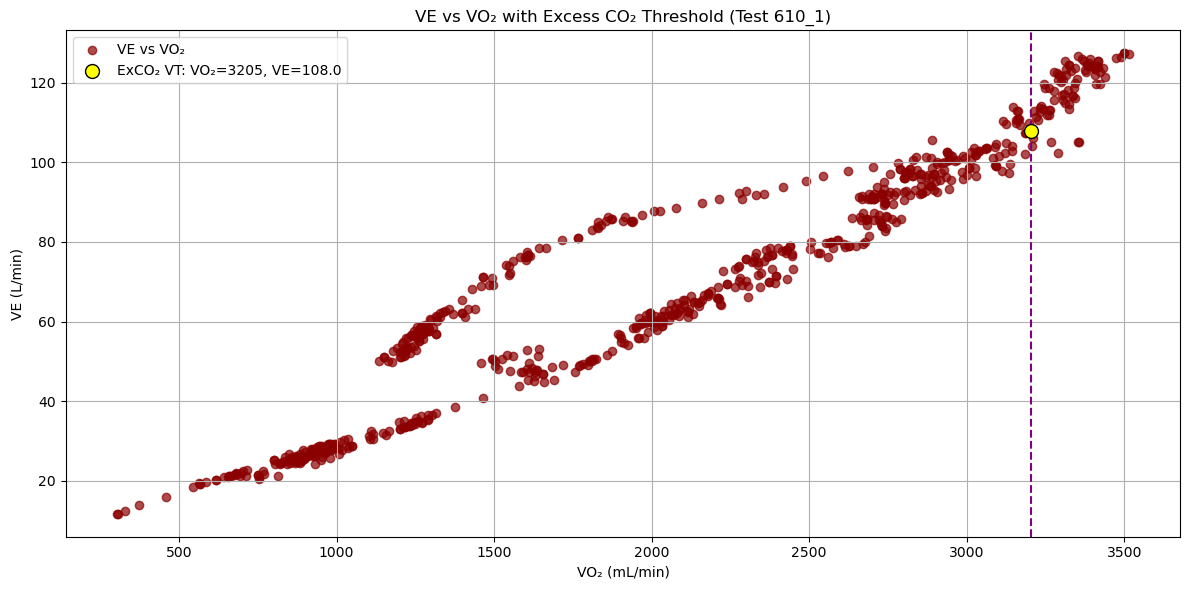

ExCO₂ VT Detected at VO₂: 3205.0 mL/min, HR: 186 bpm


In [16]:
#  METHOD 2 - Excess CO2 method

import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter

# Subset data for target test
target_id_test = "610_1"
subset = data[data['ID_test'] == target_id_test].sort_values('time')

# Preprocess data
hr = subset['HR'].values
vo2 = subset['VO2'].values
vco2 = subset['VCO2'].values
ve = subset['VE'].values

# ---- Excess CO2 Method ----
vo2_safe = vo2.copy().astype(float)
vo2_safe[vo2_safe == 0] = 1e-8  # avoid division by zero

with np.errstate(divide='ignore', invalid='ignore'):
    exco2 = np.where(
        (vco2 == 0) & (vo2 == 0),
        0,
        (vco2**2 / vo2_safe) - vco2
    )

exco2 = np.nan_to_num(exco2, nan=0.0, posinf=0.0, neginf=0.0)
window_size = min(7, len(hr)//2*2-1)
exco2_smooth = savgol_filter(exco2, window_size, 2)

threshold = np.median(exco2_smooth) + 0.5*np.std(exco2_smooth)
vt_exco2_idx = np.argmax(exco2_smooth > threshold) if np.any(exco2_smooth > threshold) else None

# ---- Plot VE vs VO2 with VT ----
plt.figure(figsize=(12, 6))
plt.scatter(vo2, ve, c='darkred', label='VE vs VO₂', alpha=0.7)

# Add VT marker and line
if vt_exco2_idx is not None and vt_exco2_idx < len(vo2):
    vt_vo2 = vo2[vt_exco2_idx]
    vt_ve = ve[vt_exco2_idx]
    plt.scatter(vt_vo2, vt_ve, color='yellow', s=100, edgecolors='black',
                label=f'ExCO₂ VT: VO₂={vt_vo2:.0f}, VE={vt_ve:.1f}', zorder=5)
    plt.axvline(x=vt_vo2, color='purple', linestyle='--')

plt.title(f'VE vs VO₂ with Excess CO₂ Threshold (Test {target_id_test})')
plt.xlabel('VO₂ (mL/min)')
plt.ylabel('VE (L/min)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Print result
if vt_exco2_idx is not None and vt_exco2_idx < len(hr):
    print(f"ExCO₂ VT Detected at VO₂: {vo2[vt_exco2_idx]:.1f} mL/min, HR: {hr[vt_exco2_idx]:.0f} bpm")
else:
    print("ExCO₂ VT could not be detected.")


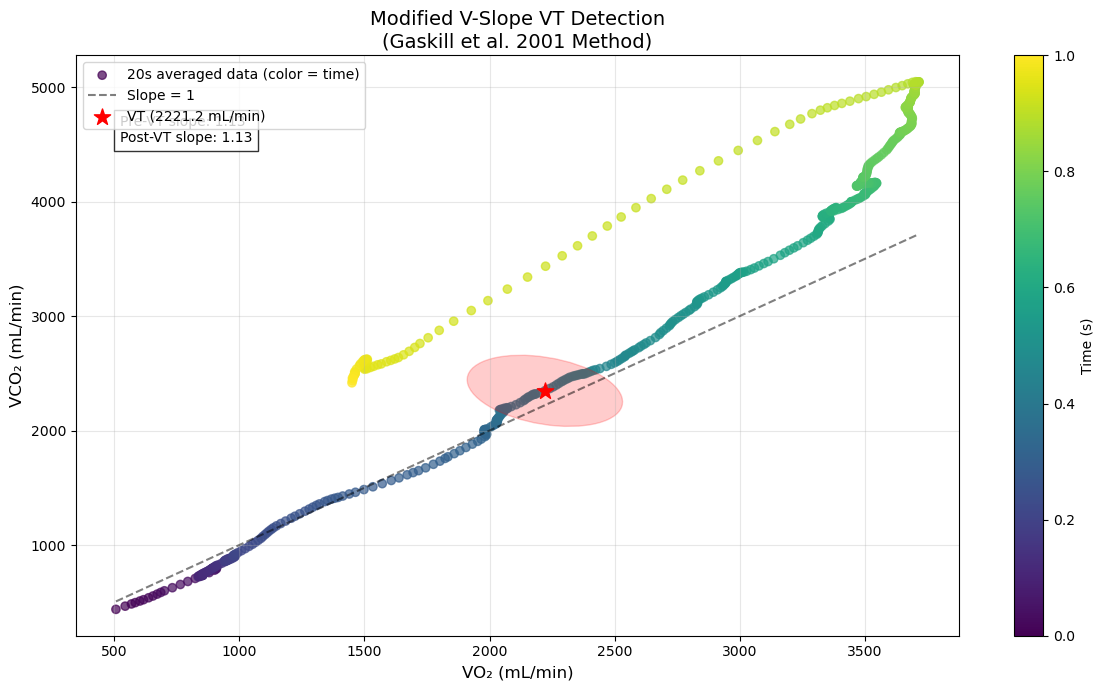


Final VT detection result: (2221.2, 517)


In [36]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from matplotlib.patches import Ellipse

def detect_ventilatory_threshold(data_path, test_id="652_1", show_plot=True):
    """
    Implements the modified V-slope method from Gaskill et al. (2001) to detect VT.
    
    Parameters:
    - data_path: Path to CSV file containing gas exchange data
    - test_id: Identifier for the test to analyze
    - show_plot: Whether to display the diagnostic plot
    
    Returns:
    - vt_vo2: VO2 at ventilatory threshold (mL/min) or None if not detected
    - vt_time: Time at VT detection (seconds) or None
    """
    
    # Load and prepare data
    try:
        data = pd.read_csv(data_path)
        subset = data[data['ID_test'] == test_id].dropna(subset=['VO2', 'VCO2', 'time'])
        subset = subset.sort_values('time')
        
        if len(subset) < 40:
            print(f"Warning: Only {len(subset)} data points - insufficient for reliable VT detection")
            return None, None
            
    except Exception as e:
        print(f"Data loading error: {str(e)}")
        return None, None

    # 20-second averaging (aligned with paper's methodology)
    subset['VO2_20s'] = subset['VO2'].rolling(window=20, min_periods=10, center=True).mean()
    subset['VCO2_20s'] = subset['VCO2'].rolling(window=20, min_periods=10, center=True).mean()
    subset = subset.dropna(subset=['VO2_20s', 'VCO2_20s']).reset_index(drop=True)
    
    # Dynamic breakpoint detection
    def find_slope_breakpoint(df):
        X = df['VO2_20s'].values.reshape(-1, 1)
        y = df['VCO2_20s'].values
        best_break = None
        min_bic = float('inf')  # Using BIC for model selection
        
        # Require at least 20% of data in each segment
        min_idx = int(len(X) * 0.2)
        max_idx = len(X) - min_idx
        
        for i in range(min_idx, max_idx):
            # Fit two linear models
            m1 = LinearRegression().fit(X[:i], y[:i])
            m2 = LinearRegression().fit(X[i:], y[i:])
            
            # Calculate Bayesian Information Criterion
            resid = np.concatenate([y[:i] - m1.predict(X[:i]), 
                                  y[i:] - m2.predict(X[i:])])
            sigma2 = np.var(resid)
            bic = len(resid)*np.log(sigma2) + 2*np.log(len(resid))
            
            # Check slope increase (critical for VT)
            if (m2.coef_[0] > m1.coef_[0]) and (bic < min_bic):
                min_bic = bic
                best_break = i
                
        return df.iloc[best_break] if best_break is not None else None
    
    # Detect VT
    vt_point = find_slope_breakpoint(subset)
    vt_vo2 = vt_point['VO2_20s'] if vt_point is not None else None
    vt_time = vt_point['time'] if vt_point is not None else None
    
    # Quality checks (per Gaskill et al. 2001)
    if vt_time is not None:
        if vt_time < 500: # 240
            print(f"VT detected at {vt_time:.1f}s (rejected - occurs before 4 minutes)")
            vt_vo2, vt_time = None, None
        elif vt_vo2 > subset['VO2_20s'].max() * 0.9:
            print(f"VT detected at {vt_vo2:.1f} mL/min (rejected - too close to VO2max)")
            vt_vo2, vt_time = None, None
    
    # Visualization
    if show_plot:
        plt.figure(figsize=(12, 7))
        
        # Main V-slope plot
        plt.scatter(subset['VO2_20s'], subset['VCO2_20s'], 
                   c=subset['time'], cmap='viridis', alpha=0.7, 
                   label='20s averaged data (color = time)')
        
        # Reference lines
        x_range = np.linspace(subset['VO2_20s'].min(), subset['VO2_20s'].max(), 100)
        plt.plot(x_range, x_range, 'k--', alpha=0.5, label='Slope = 1')
        
        if vt_point is not None:
            # Mark VT with uncertainty ellipse
            ellipse = Ellipse(xy=(vt_vo2, vt_point['VCO2_20s']),
                            width=subset['VO2_20s'].std()/2,
                            height=subset['VCO2_20s'].std()/2,
                            angle=45, color='red', alpha=0.2)
            plt.gca().add_patch(ellipse)
            
            plt.scatter(vt_vo2, vt_point['VCO2_20s'], 
                       color='red', s=150, marker='*',
                       label=f'VT ({vt_vo2:.1f} mL/min)')
            
            # Add slope info
            pre_idx = subset.index.get_loc(vt_point.name)
            pre_slope = LinearRegression().fit(
                subset.iloc[:pre_idx]['VO2_20s'].values.reshape(-1,1),
                subset.iloc[:pre_idx]['VCO2_20s'].values).coef_[0]
            
            post_slope = LinearRegression().fit(
                subset.iloc[pre_idx:]['VO2_20s'].values.reshape(-1,1),
                subset.iloc[pre_idx:]['VCO2_20s'].values).coef_[0]
            
            plt.text(0.05, 0.85, 
                    f'Pre-VT slope: {pre_slope:.2f}\nPost-VT slope: {post_slope:.2f}',
                    transform=plt.gca().transAxes, bbox=dict(facecolor='white', alpha=0.8))
        
        plt.xlabel('VO₂ (mL/min)', fontsize=12)
        plt.ylabel('VCO₂ (mL/min)', fontsize=12)
        plt.title('Modified V-Slope VT Detection\n(Gaskill et al. 2001 Method)', fontsize=14)
        plt.legend(loc='upper left')
        plt.grid(True, alpha=0.3)
        plt.colorbar(label='Time (s)')
        plt.tight_layout()
        plt.show()
    
    return vt_vo2, vt_time

# Example usage
if __name__ == "__main__":
    vt_result = detect_ventilatory_threshold('test_measure.csv')
    print(f"\nFinal VT detection result: {vt_result}")

Ventilatory Threshold Results:
VEQ: 4066.0 mL/min
Excess CO2: 3977.0 mL/min
V-Slope: 3812.8 mL/min


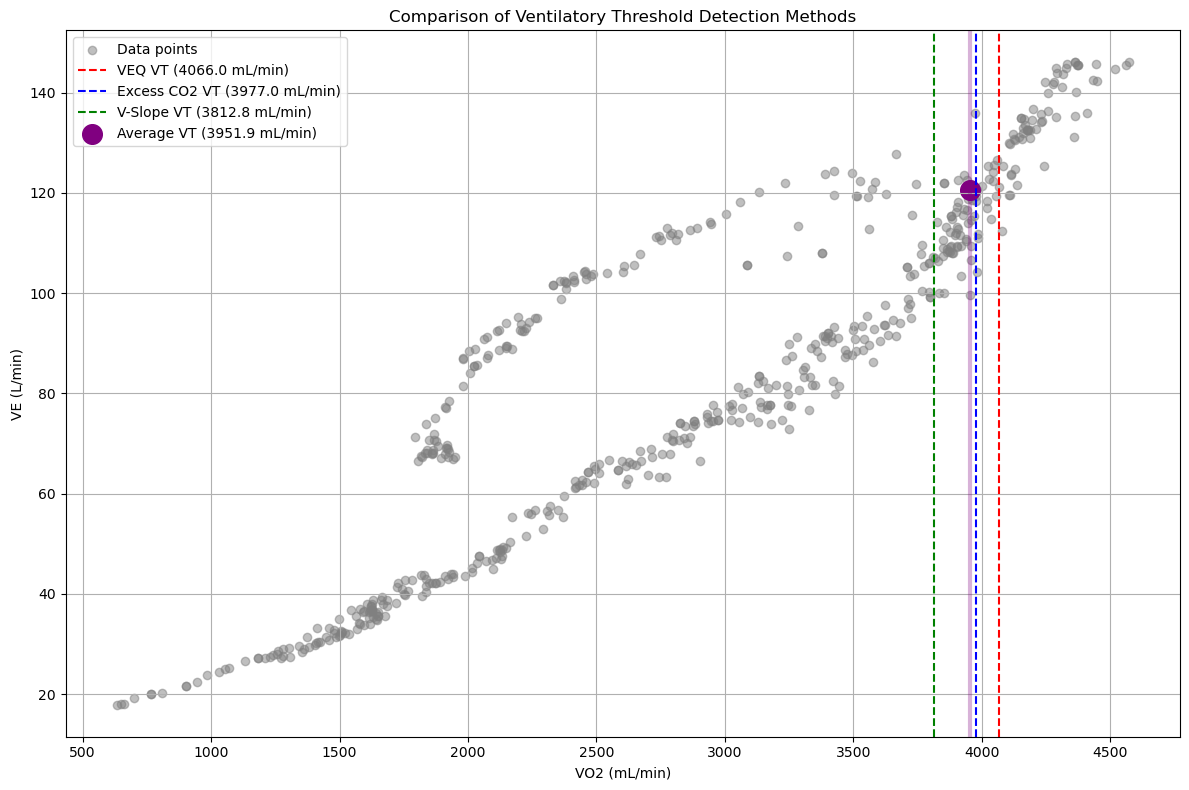

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import IsolationForest
from scipy.signal import savgol_filter
from matplotlib.patches import Ellipse

def load_data(data_path, test_id):
    """Load and prepare the dataset"""
    data = pd.read_csv(data_path)
    subset = data[data['ID_test'] == test_id].sort_values('time')
    subset = subset.dropna(subset=['VO2', 'VE', 'VCO2', 'time'])
    return subset

def veq_method(data, show_plot=False):
    """Method 1: VEQ Method"""
    # Filter anomalies
    features = data[['VO2', 'VE']].values
    iso_forest = IsolationForest(contamination=0.10, random_state=42)
    outlier_labels = iso_forest.fit_predict(features)
    filtered_data = data[outlier_labels == 1]
    
    x = filtered_data['VO2'].values
    y = filtered_data['VE'].values
    
    # Find best split point
    def find_best_split(x, y, min_points=5):
        best_split, min_error = None, float('inf')
        for i in range(min_points, len(x) - min_points):
            model1 = LinearRegression().fit(x[:i].reshape(-1,1), y[:i])
            model2 = LinearRegression().fit(x[i:].reshape(-1,1), y[i:])
            total_error = (
                np.sum((y[:i] - model1.predict(x[:i].reshape(-1, 1)))**2) +
                np.sum((y[i:] - model2.predict(x[i:].reshape(-1, 1)))**2)
            )

            if total_error < min_error:
                min_error = total_error
                best_split = i
        return best_split
    
    split_idx = find_best_split(x, y)
    vt_vo2 = x[split_idx] if split_idx is not None else None
    
    if show_plot:
        plt.figure()
        plt.scatter(x, y, color='blue', label='Filtered Data')
        if vt_vo2:
            plt.axvline(vt_vo2, color='red', linestyle='--', label='VEQ VT')
        plt.xlabel('VO2')
        plt.ylabel('VE')
        plt.title('VEQ Method')
        plt.legend()
        plt.show()
    
    return vt_vo2

def excess_co2_method(data, show_plot=False):
    """Method 2: Excess CO2 Method"""
    vo2 = data['VO2'].values
    vco2 = data['VCO2'].values
    ve = data['VE'].values
    
    # Calculate excess CO2
    vo2_safe = vo2.copy().astype(float)
    vo2_safe[vo2_safe == 0] = 1e-8
    exco2 = np.where((vco2 == 0) & (vo2 == 0), 0, (vco2**2 / vo2_safe) - vco2)
    exco2 = np.nan_to_num(exco2, nan=0.0, posinf=0.0, neginf=0.0)
    
    # Smooth and find threshold
    window_size = min(7, len(vo2)//2*2-1)
    exco2_smooth = savgol_filter(exco2, window_size, 2)
    threshold = np.median(exco2_smooth) + 0.5*np.std(exco2_smooth)
    vt_idx = np.argmax(exco2_smooth > threshold) if np.any(exco2_smooth > threshold) else None
    vt_vo2 = vo2[vt_idx] if vt_idx is not None else None
    
    if show_plot:
        plt.figure()
        plt.scatter(vo2, ve, c='darkred', label='VE vs VO2')
        if vt_vo2:
            plt.axvline(vt_vo2, color='purple', linestyle='--', label='ExCO2 VT')
        plt.title('Excess CO2 Method')
        plt.legend()
        plt.show()
    
    return vt_vo2

def v_slope_method(data, show_plot=False):
    """Method 3: Modified V-slope Method"""
    # 20-second averaging
    data = data.sort_values('time')
    data['VO2_20s'] = data['VO2'].rolling(window=20, min_periods=10, center=True).mean()
    data['VCO2_20s'] = data['VCO2'].rolling(window=20, min_periods=10, center=True).mean()
    data = data.dropna(subset=['VO2_20s', 'VCO2_20s'])
    
    # Find slope breakpoint
    def find_slope_breakpoint(df):
        X = df['VO2_20s'].values.reshape(-1, 1)
        y = df['VCO2_20s'].values
        best_break, min_bic = None, float('inf')
        min_idx, max_idx = int(len(X)*0.2), len(X) - int(len(X)*0.2)
        
        for i in range(min_idx, max_idx):
            m1 = LinearRegression().fit(X[:i], y[:i])
            m2 = LinearRegression().fit(X[i:], y[i:])
            resid = np.concatenate([y[:i] - m1.predict(X[:i]), y[i:] - m2.predict(X[i:])])
            sigma2 = np.var(resid)
            bic = len(resid)*np.log(sigma2) + 2*np.log(len(resid))
            
            if (m2.coef_[0] > m1.coef_[0]) and (bic < min_bic):
                min_bic = bic
                best_break = i
                
        return df.iloc[best_break] if best_break is not None else None
    
    vt_point = find_slope_breakpoint(data)
    vt_vo2 = vt_point['VO2_20s'] if vt_point is not None else None
    
    if show_plot:
        plt.figure()
        plt.scatter(data['VO2_20s'], data['VCO2_20s'], c=data['time'], cmap='viridis')
        if vt_point is not None:
            plt.scatter(vt_vo2, vt_point['VCO2_20s'], color='red', s=150, marker='*')
        plt.title('V-Slope Method')
        plt.show()
    
    return vt_vo2

def calculate_average_threshold(results):
    """Calculate average of detected thresholds"""
    valid_thresholds = [vt for vt in results.values() if vt is not None]
    if not valid_thresholds:
        return None
    return np.mean(valid_thresholds)

def plot_comparison(data, results):
    """Plot all results on VE vs VO2 plot"""
    plt.figure(figsize=(12, 8))
    
    # Plot main data
    plt.scatter(data['VO2'], data['VE'], color='gray', alpha=0.5, label='Data points')
    
    # Plot each method's VT
    colors = ['red', 'blue', 'green']
    methods = ['VEQ', 'Excess CO2', 'V-Slope']
    
    for (method, vt_vo2), color in zip(results.items(), colors):
        if vt_vo2 is not None:
            plt.axvline(vt_vo2, color=color, linestyle='--', 
                       label=f'{method} VT ({vt_vo2:.1f} mL/min)')
    
    # Calculate and plot average threshold
    avg_threshold = calculate_average_threshold(results)
    if avg_threshold is not None:
        # Find corresponding VE value nearest to the average VO2
        idx = np.abs(data['VO2'] - avg_threshold).argmin()
        avg_ve = data.iloc[idx]['VE']
        
        plt.scatter(avg_threshold, avg_ve, color='purple', s=200, 
                   marker='o', label=f'Average VT ({avg_threshold:.1f} mL/min)')
        plt.axvline(avg_threshold, color='purple', alpha=0.3, linewidth=3)
    
    plt.xlabel('VO2 (mL/min)')
    plt.ylabel('VE (L/min)')
    plt.title('Comparison of Ventilatory Threshold Detection Methods')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    

def main():
    # Load data
    data_path = 'test_measure.csv'
    test_id = "634_1"
    data = load_data(data_path, test_id)
    
    # Run all methods
    results = {
        'VEQ': veq_method(data),
        'Excess CO2': excess_co2_method(data),
        'V-Slope': v_slope_method(data)
    }
    
    # Print results
    print("Ventilatory Threshold Results:")
    for method, vt in results.items():
        print(f"{method}: {vt:.1f} mL/min" if vt else f"{method}: Not detected")
    
    # Plot comparison
    plot_comparison(data, results)

if __name__ == "__main__":
    main()